# Decoding Emotions: Sentiment Analysis on Twitter Data
## Nicolás Romeu García | 1674080

In [2]:
import kagglehub
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import CategoricalNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer

import re
import emoji
import os
import matplotlib.pyplot as plt
import random

import seaborn as sns
import string
import numpy as np
import random
from plotly import graph_objs as go

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.optimizers import Adam

C:\Users\Nicolás\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LOADING DATASET

In [3]:
path = kagglehub.dataset_download("yasserh/twitter-tweets-sentiment-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Nicolás\.cache\kagglehub\datasets\yasserh\twitter-tweets-sentiment-dataset\versions\1


In [4]:
file_path = os.path.join(path, "Tweets.csv")

original_df = pd.read_csv(file_path, encoding="latin1")
original_df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

### DATA CLEANING & PREPROCESSING

#### **Dropping columns**

To predict the sentiment behind the tweet using BOW and Bayesian Probability, we will have to drop some columns:
- `textID`: Unique identificator for each tweet, it doesn't add any info to the sentiment so we can drop the column

- `selected_text`: Using this column would be a little bit of cheating as we are precisely trying to predict which words are the most related to each sentiment and selected_text is already giving us that info. Although we can use the column later on to compare the results of our prediction with the selected text in the dataset, we will drop if for now.

In [188]:
df = original_df.drop(['textID', 'selected_text'], axis=1)
df.head()

text sentiment
0                I`d have responded, if I were going   neutral
1      Sooo SAD I will miss you here in San Diego!!!  negative
2                          my boss is bullying me...  negative
3                     what interview! leave me alone  negative
4   Sons of ****, why couldn`t they put them on t...  negative

#### **Quick look at our data**

Let's take a little look into the way data is organized in our dataset, we will visualize better our data later on.

In [189]:
temp = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues_r')

#### **Mapping labels**

Original target labels are 4 for positive, 2 for neutral and 0 for negative, but i think it would be easier to interprate and more intuitive if i changed the labels to 2 for positive, 1 for neutral and 0 for negative

In [190]:
# Mapping labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive':2}
df['sentiment'] = df['sentiment'].map(label_mapping)

df.head()

text  sentiment
0                I`d have responded, if I were going          1
1      Sooo SAD I will miss you here in San Diego!!!          0
2                          my boss is bullying me...          0
3                     what interview! leave me alone          0
4   Sons of ****, why couldn`t they put them on t...          0

#### **Cleaning data**

Let's make sure that there aren't any empty cells on our dataset and that we can work with all the data properly.

In [191]:
# Let's see if there are any NaN's in our tweets and treat them in case there are
print("There is a total of", df["text"].isna().sum(), "NaN's")
df["text"] = df["text"].fillna("")

There is a total of 1 NaN's


In [192]:
print("After cleaning the column there are", df["text"].isna().sum(), "NaN's")

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_tweet(tweet, remove_stopwords=True):
    if not isinstance(tweet, str):
        return ""
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#\w+", "", tweet)
    tweet = re.sub(r"http\S+|www\S+", "", tweet)
    tweet = emoji.demojize(tweet)
    tweet = re.sub(r"[^a-zA-Z\s\*]", "", tweet)
    tweet = tweet.lower().strip()

    if remove_stopwords:
        tweet_2 = " ".join([word for word in tweet.split() if word not in stop_words])
        if tweet_2 == "":
            return tweet

    return tweet_2

df["cleaned_text"] = df["text"].apply(lambda x: preprocess_tweet(x, remove_stopwords=True))


After cleaning the column there are 0 NaN's


In [193]:
empty_count = df[df["cleaned_text"] == ""].shape[0]
print(f"Number of rows with empty text: {empty_count}")

df = df[df["cleaned_text"] != ""]
empty_count = df[df["cleaned_text"] == ""].shape[0]
print(f"After dropping the rows there are {empty_count} with empty text")

Number of rows with empty text: 6
After dropping the rows there are 0 with empty text


In [194]:
df = df.drop('text', axis=1)
df.head(10)

sentiment                                   cleaned_text
0          1                             id responded going
1          0                        sooo sad miss san diego
2          0                                  boss bullying
3          0                          interview leave alone
4          0  sons **** couldnt put releases already bought
5          1    shameless plugging best rangers forum earth
6          2                  feedings baby fun smiles coos
7          1                                     soooo high
8          1                                    both of you
9          2      journey wow u became cooler hehe possible

#### **Data visualization**

Let's visualize how the data is distributed, what words are the most common and how the sentiments are distributed along the dataset

In [195]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

#### **Most Common Words**

In [196]:
import plotly.express as px
from collections import Counter

df['split_text'] = df['cleaned_text'].apply(lambda x: x.split())
top = Counter([item for sublist in df['split_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Frequent Words','Count']
temp.style.background_gradient(cmap='Blues')

#### **WordClouds and most common words for each sentiment**

In [197]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

positive_sentiment = df[df['sentiment']==2]
negative_sentiment = df[df['sentiment']==0]
neutral_sentiment = df[df['sentiment']==1]

mask = np.array(Image.open('C:/Users/Nicolás/Desktop/MatCad/MatCad_3/APC/Cas_kaggle/APC/twitter_mask.png'))
mask[mask.sum(axis=2) == 0] = 255

def plot_wordcloud(text, title, title_size):
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)

    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.5,
        contour_color='white',
    ).generate_from_frequencies(dict(mostcommon))   

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

##### Positive sentiment

In [198]:
top = Counter([item for sublist in positive_sentiment['split_text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Frequent words','Count']
temp_positive.style.background_gradient(cmap='Greens')

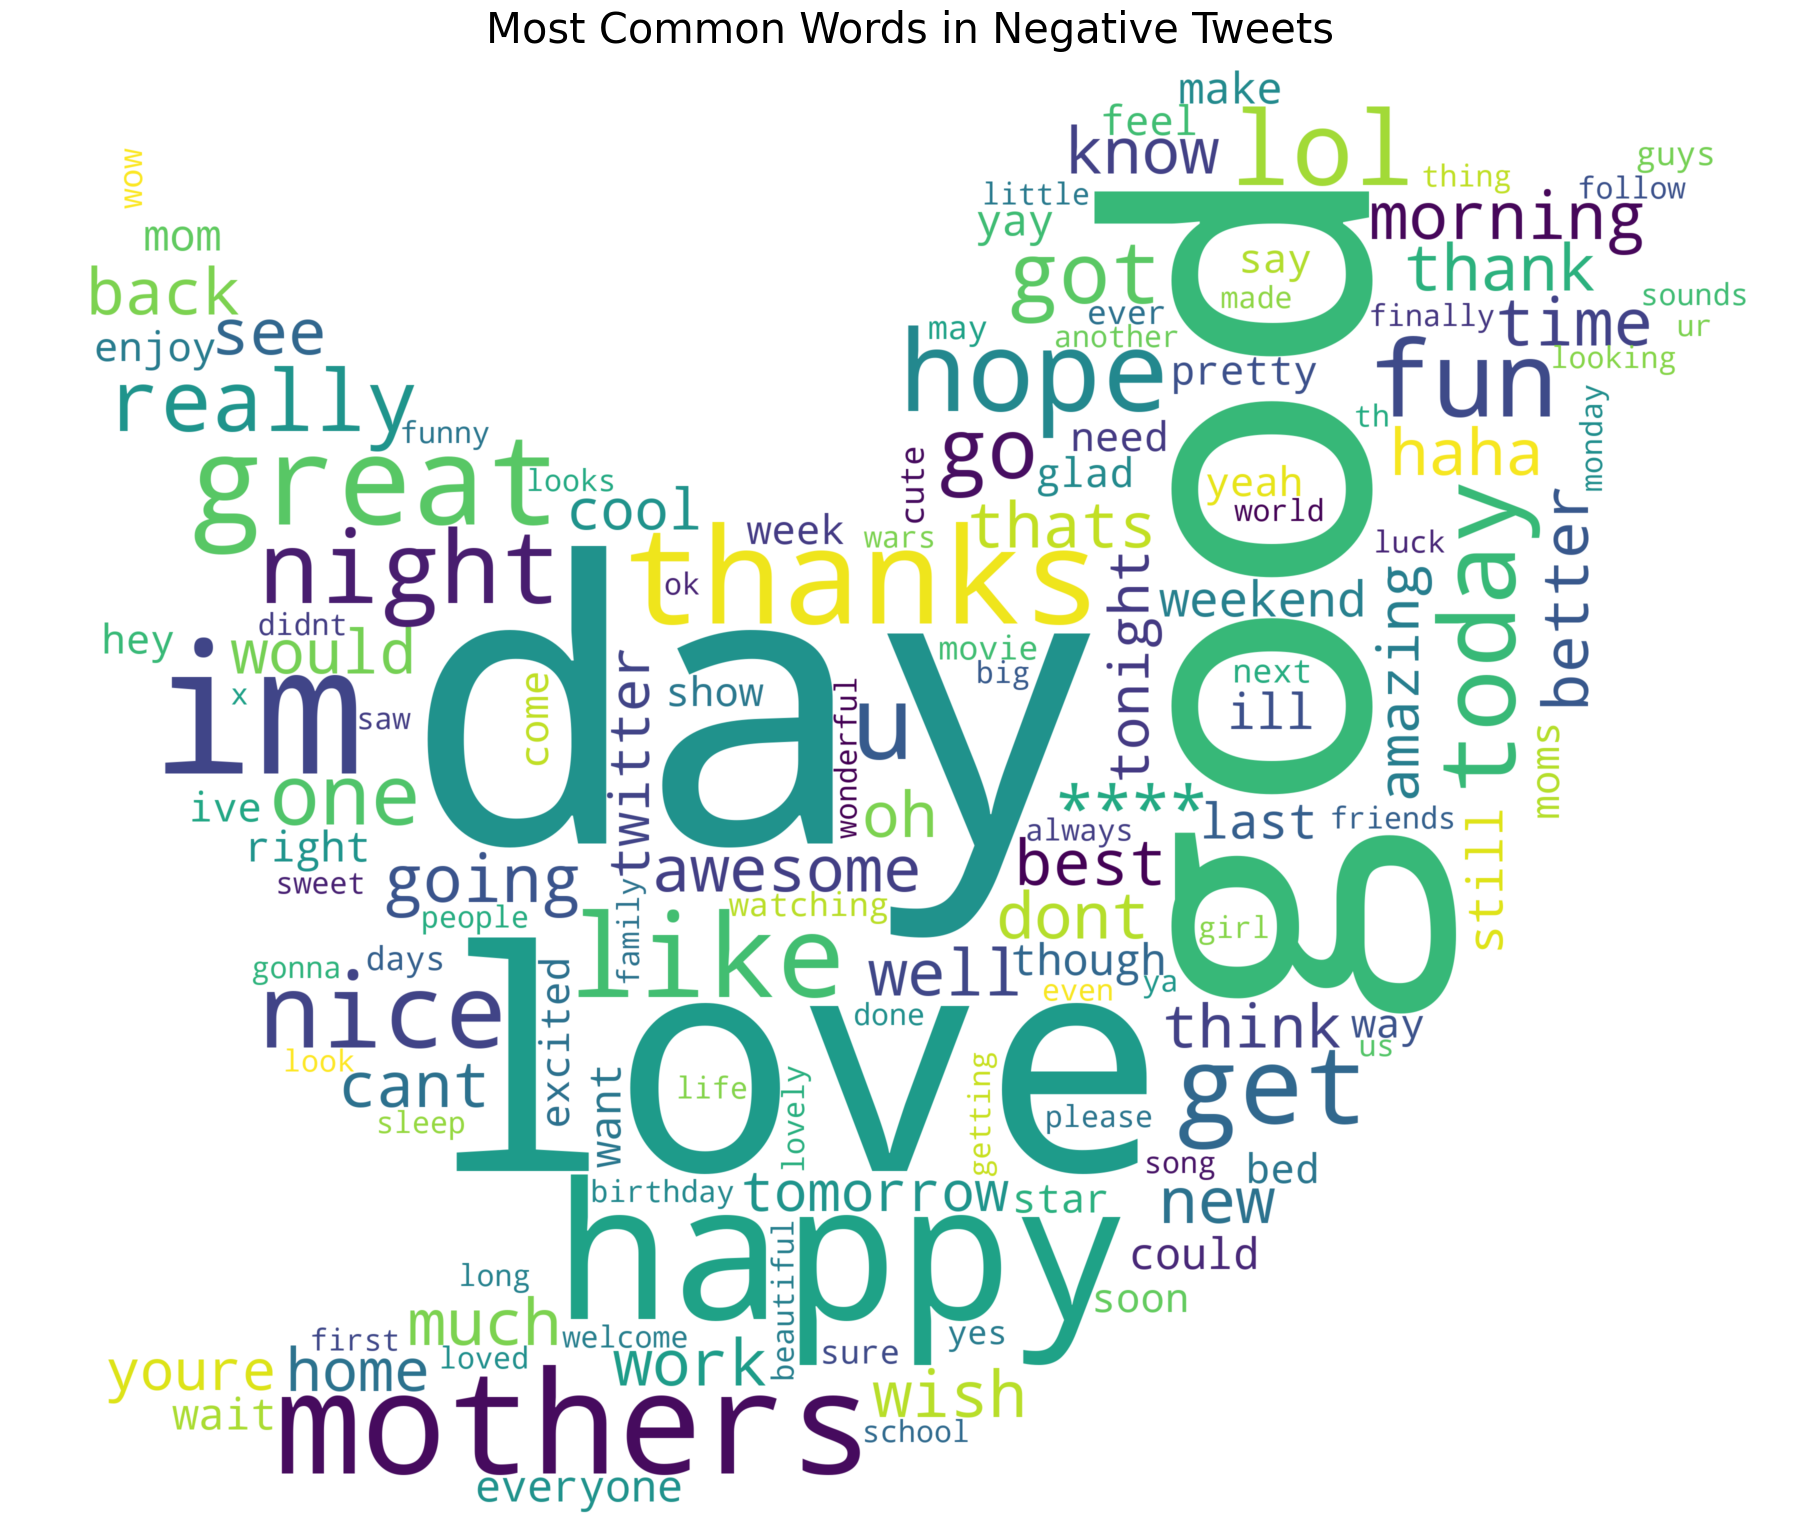

In [199]:
plot_wordcloud(df[df['sentiment'] == 2]['split_text'],'Most Common Words in Negative Tweets',title_size=30)

##### Neutral sentiment

In [200]:
top = Counter([item for sublist in neutral_sentiment['split_text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Frequent words','Count']
temp_positive.style.background_gradient(cmap='Grays')

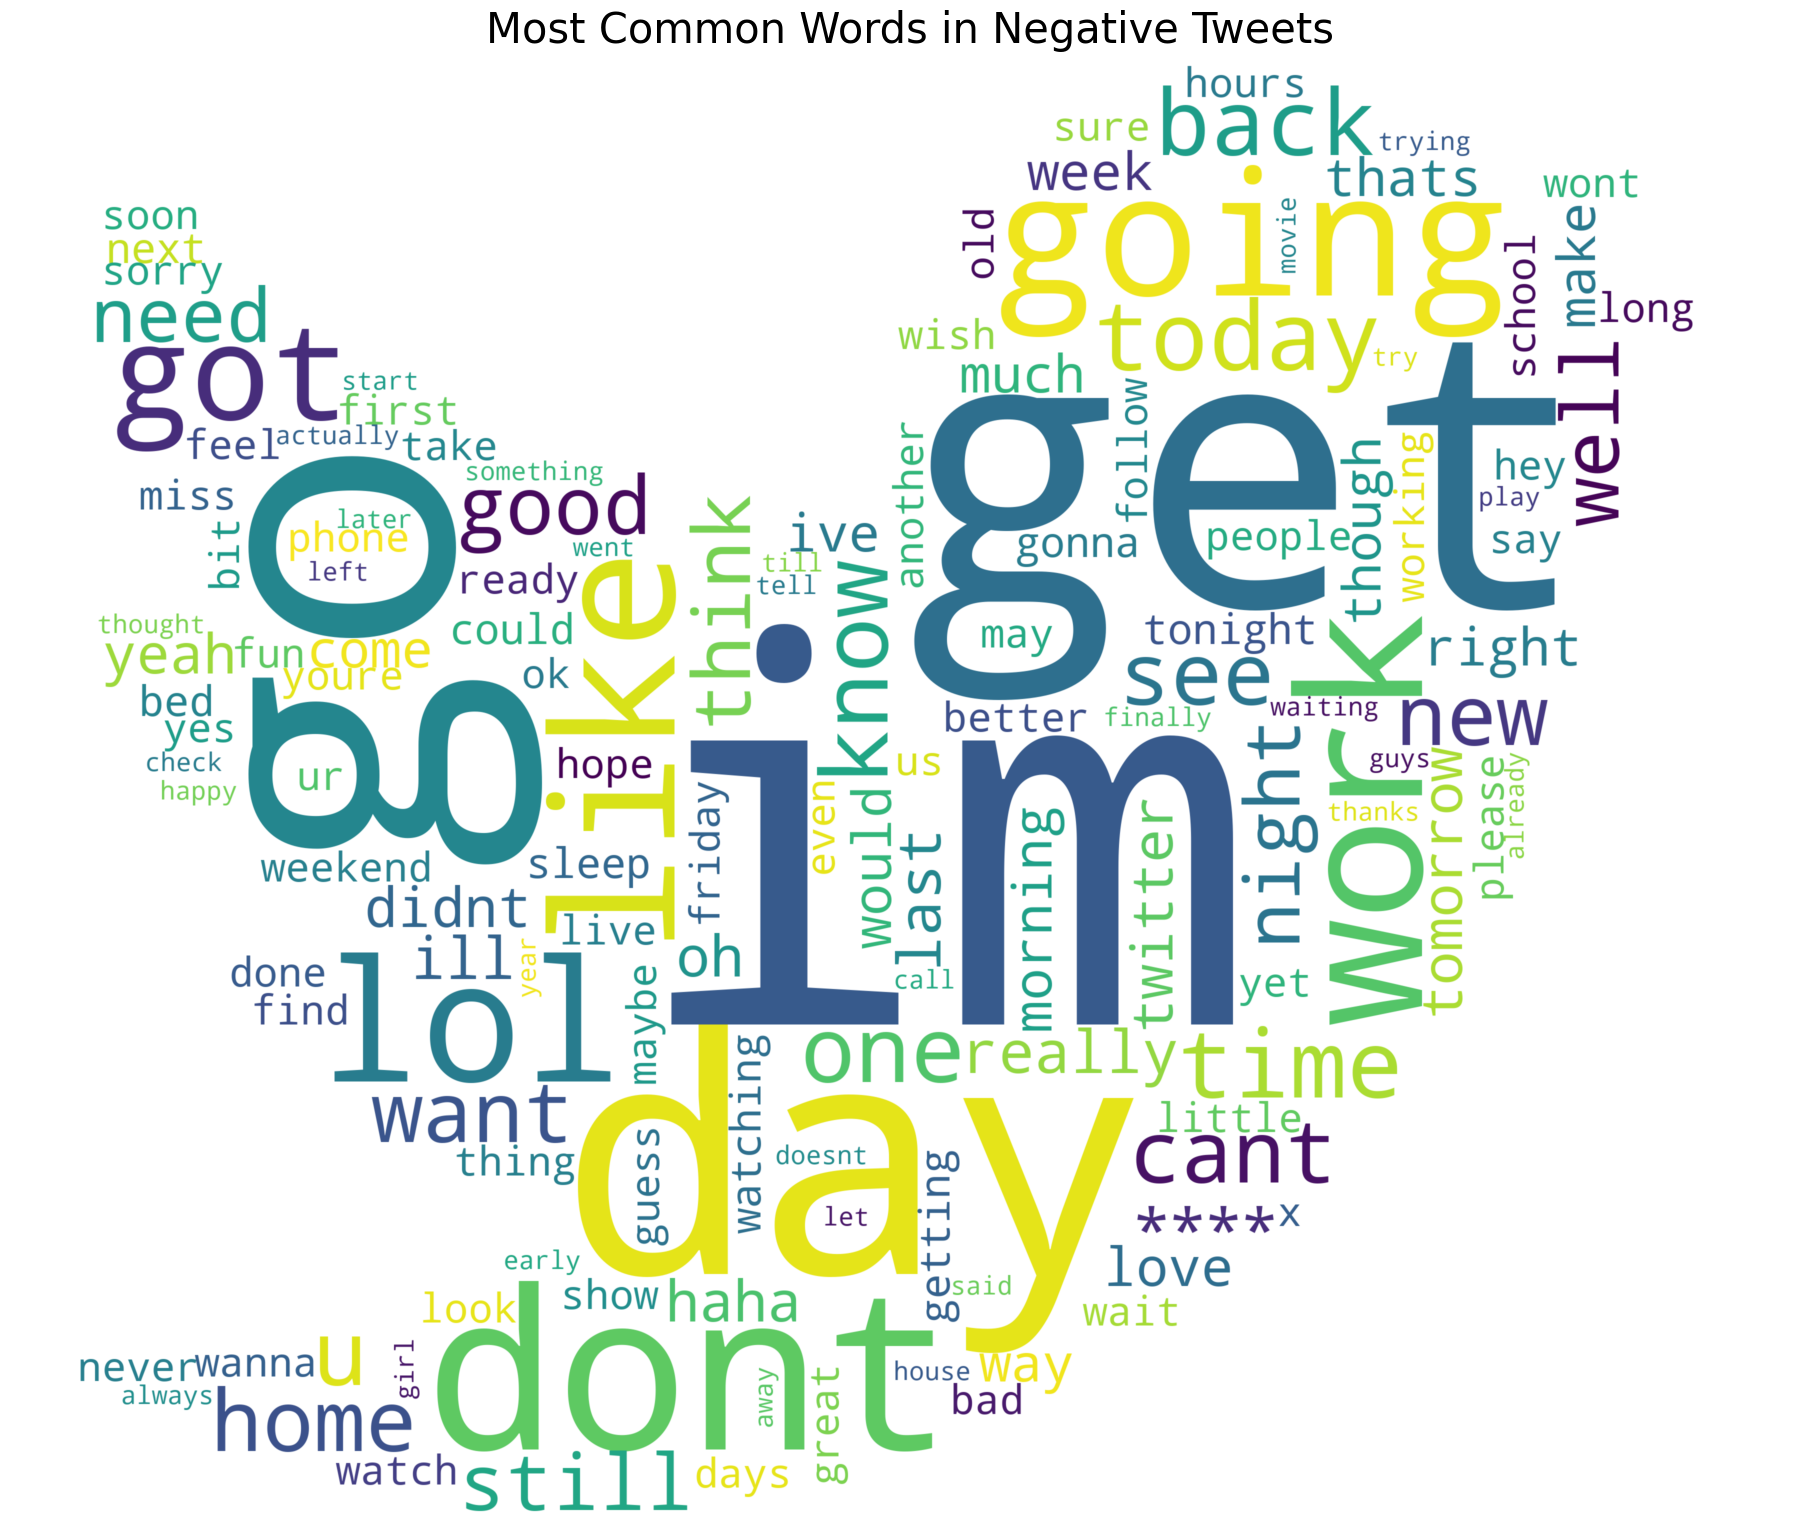

In [201]:
plot_wordcloud(df[df['sentiment'] == 1]['split_text'],'Most Common Words in Negative Tweets',title_size=30)

##### Negative sentiment

In [202]:
top = Counter([item for sublist in negative_sentiment['split_text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Frequent words','Count']
temp_positive.style.background_gradient(cmap='Reds')

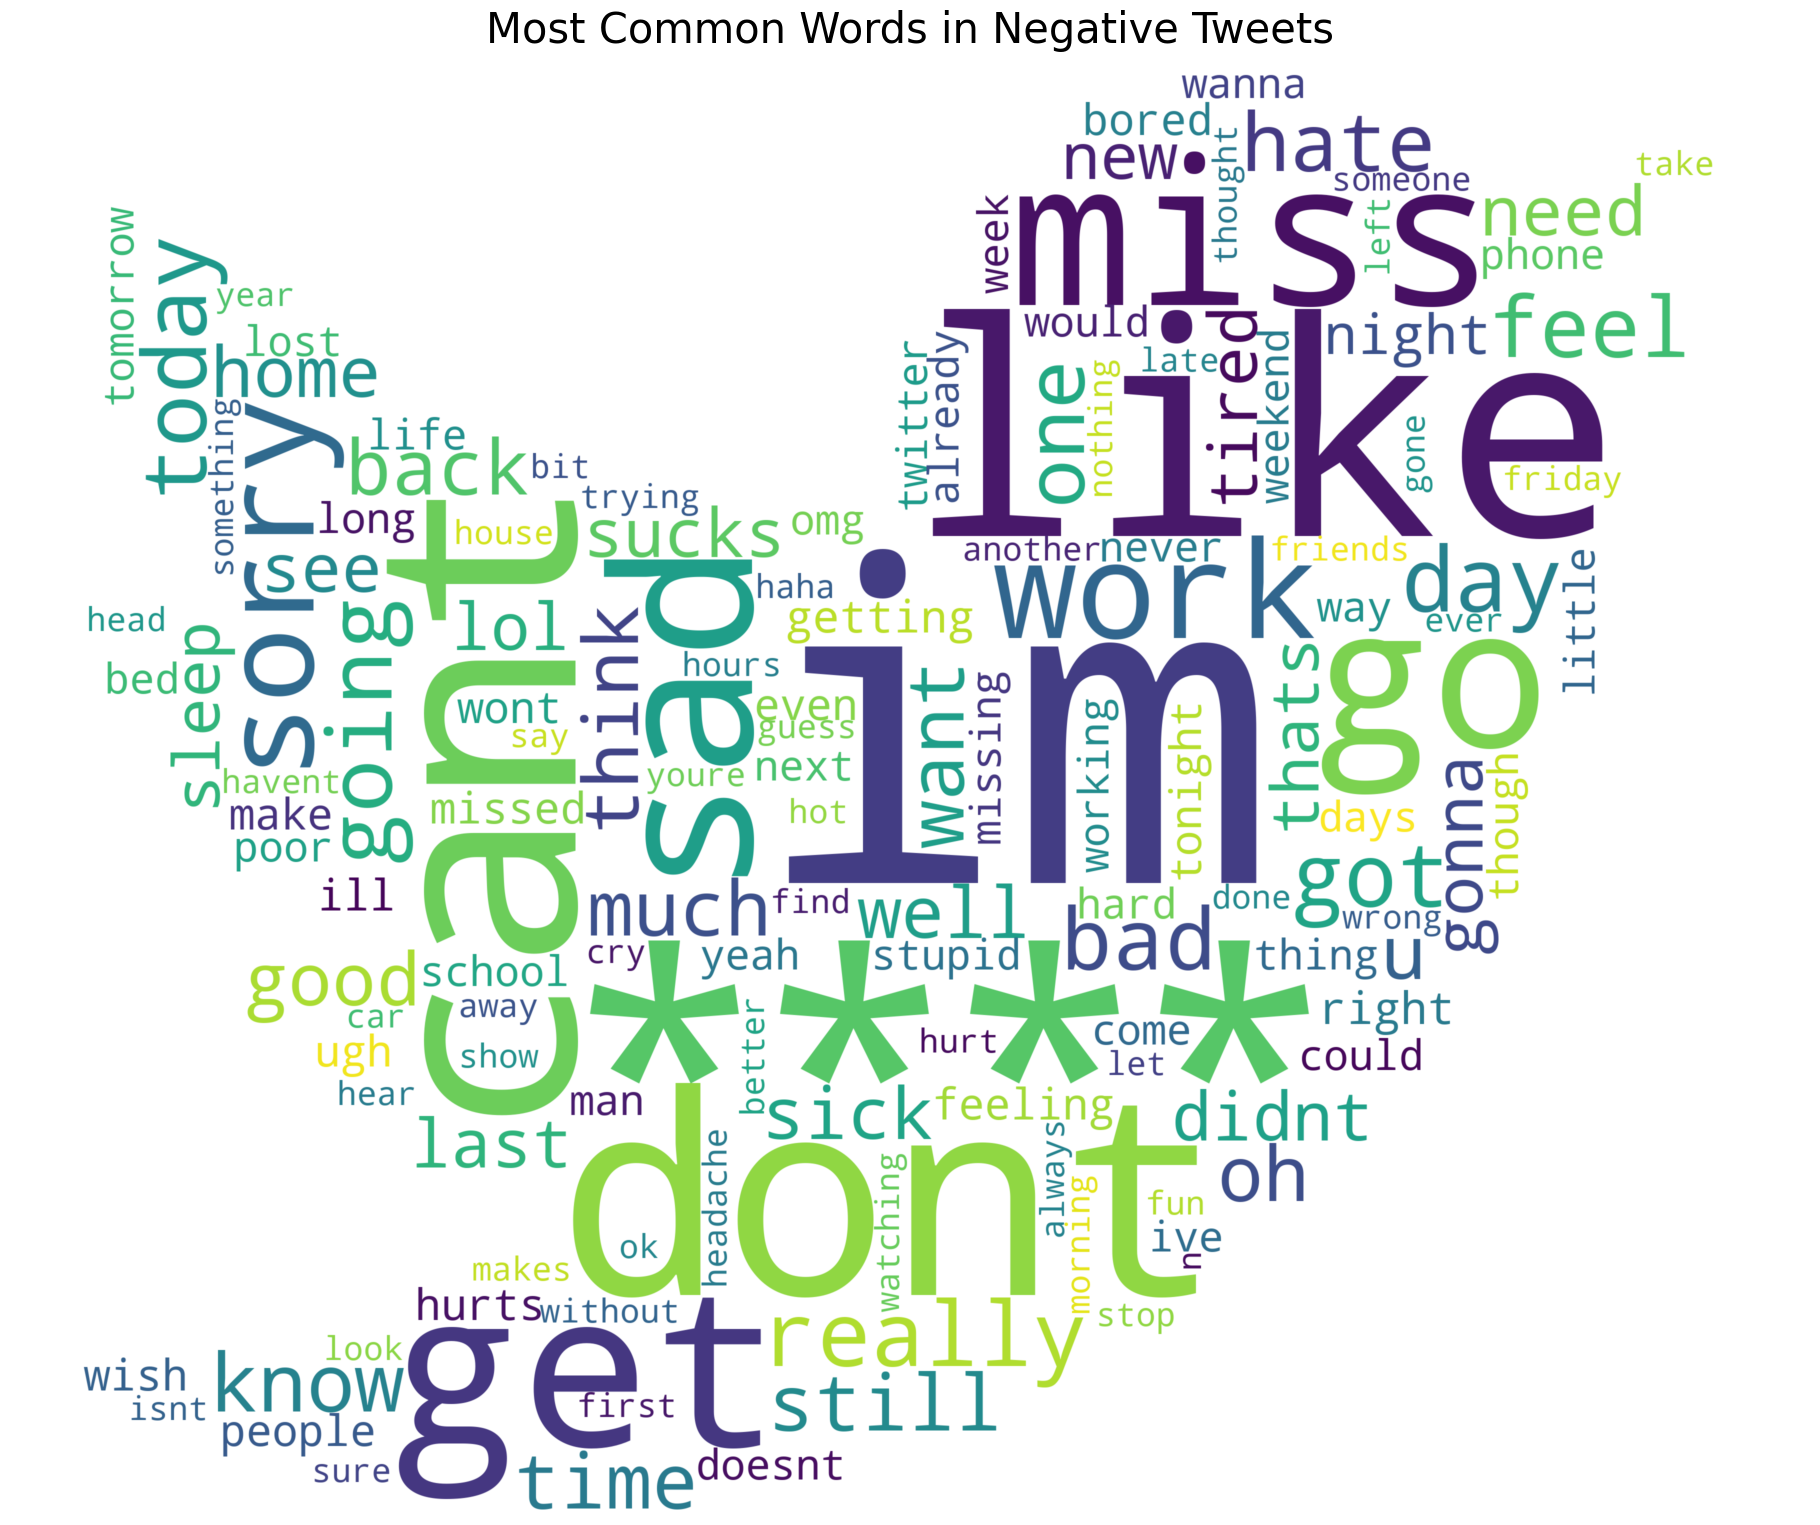

In [203]:
plot_wordcloud(df[df['sentiment'] == 0]['split_text'],'Most Common Words in Negative Tweets',title_size=30)

As we can see, 'im' is a very common word for the three different sentiments and it doesn't add any information at all, so I decided to modify a little the function `remove_stop_words` so it also deletes the word 'im'

In [204]:
def preprocess_tweet(tweet, remove_stopwords=True):
    if not isinstance(tweet, str):
        return ""
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#\w+", "", tweet)
    tweet = re.sub(r"http\S+|www\S+", "", tweet)
    tweet = emoji.demojize(tweet)
    tweet = re.sub(r"[^a-zA-Z\s\*]", "", tweet)
    tweet = tweet.lower().strip()

    stopwords = stop_words.copy()
    stopwords.add("im")
    if remove_stopwords:
        tweet_2 = " ".join([word for word in tweet.split() if word not in stopwords])
        if tweet_2 == "":
            return tweet

    return tweet_2

df["cleaned_text"] = df["cleaned_text"].apply(lambda x: preprocess_tweet(x, remove_stopwords=True))

## CLASSIFICATION

Now we will divide our data into train and test and start training our model to be able to predict.

### Metric Selection

In [205]:
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["sentiment"], test_size=0.2, random_state=42)

vectorizer = CountVectorizer(max_features=10000, stop_words="english")
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.58      0.62      1563
     Neutral       0.59      0.67      0.63      2199
    Positive       0.72      0.70      0.71      1733

    accuracy                           0.65      5495
   macro avg       0.66      0.65      0.65      5495
weighted avg       0.66      0.65      0.65      5495

Confusion Matrix:
[[ 903  562   98]
 [ 349 1464  386]
 [  77  440 1216]]


I have decided to use the `f1_macro` scoring metric as there is a small imbalance on my data and this metric gives a balanced insight of the performance of each class instead of focusing on the most dominant one.

### Classification using TF-IDF (Term Frequency - Inverse Document Frequency)

In [206]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text']).toarray()  # Convertimos el texto a TF-IDF y lo pasamos a array
y = df['sentiment']  # Etiquetas

# Configuración de k-fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista de clasificadores Naive Bayes
classifiers = [
    MultinomialNB(),
    LogisticRegression(max_iter=500, random_state=42),
    BernoulliNB(),
    ComplementNB()
]

# Evaluación de los modelos con cross-validation
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X, y, scoring="f1_macro", cv=kfold, n_jobs=-1))

# Calcular medias y desviaciones estándar de los resultados
cv_means = [result.mean() for result in cv_results]
cv_std = [result.std() for result in cv_results]

# Crear un DataFrame con los resultados
cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValErrors": cv_std,
    "Algorithm": ["MultinomialNB", "LogisticRegression", "BernoulliNB", "ComplementNB"]
})
cv_res = cv_res.sort_values(by="CrossValMeans", ascending=True)

# Visualización de los resultados
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.7, 0.3],
    specs=[[{"type": "bar"}, {"type": "table"}]],
    subplot_titles=("Cross Validation F1 Scores", "Cross Validation Error Table")
)

# Gráfico de barras
fig.add_trace(go.Bar(
    x=cv_res['CrossValMeans'],
    y=cv_res['Algorithm'],
    orientation='h',  # Barras horizontales
    error_x=dict(type='data', array=cv_res['CrossValErrors']),
    marker=dict(color=cv_res['CrossValMeans'], colorscale='Agsunset')
), row=1, col=1)

# Tabla de resultados
fig.add_trace(go.Table(
    header=dict(values=["Algorithm", "Cross Validation Means", "Cross Validation Errors"],
                fill_color='grey',
                align='left'),
    cells=dict(values=[cv_res['Algorithm'], cv_res['CrossValMeans'], cv_res['CrossValErrors']],
               fill_color='black',
               align='left')
), row=1, col=2)

# Configuración del layout
fig.update_layout(
    height=600,
    showlegend=False,
    template="plotly_dark"
)

# Mostrar la gráfica
fig.show()

### Classification using BoW (Bag of Words)

In [207]:
# Vectorización BoW
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text']).toarray()  # Convertimos el texto a TF-IDF y lo pasamos a array
y = df['sentiment']  # Etiquetas

# Configuración de k-fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista de clasificadores Naive Bayes
classifiers = [
    MultinomialNB(),
    LogisticRegression(),
    BernoulliNB(),
    ComplementNB()
]

# Evaluación de los modelos con cross-validation
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X, y, scoring="f1_macro", cv=kfold, n_jobs=-1))

# Calcular medias y desviaciones estándar de los resultados
cv_means = [result.mean() for result in cv_results]
cv_std = [result.std() for result in cv_results]

# Crear un DataFrame con los resultados
cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValErrors": cv_std,
    "Algorithm": ["MultinomialNB", "LogisticRegression", "BernoulliNB", "ComplementNB"]
})
cv_res = cv_res.sort_values(by="CrossValMeans", ascending=True)

# Visualización de los resultados
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.7, 0.3],
    specs=[[{"type": "bar"}, {"type": "table"}]],
    subplot_titles=("Cross Validation F1 Scores", "Cross Validation Error Table")
)

# Gráfico de barras
fig.add_trace(go.Bar(
    x=cv_res['CrossValMeans'],
    y=cv_res['Algorithm'],
    orientation='h',  # Barras horizontales
    error_x=dict(type='data', array=cv_res['CrossValErrors']),
    marker=dict(color=cv_res['CrossValMeans'], colorscale='Agsunset')
), row=1, col=1)

# Tabla de resultados
fig.add_trace(go.Table(
    header=dict(values=["Algorithm", "Cross Validation Means", "Cross Validation Errors"],
                fill_color='grey',
                align='left'),
    cells=dict(values=[cv_res['Algorithm'], cv_res['CrossValMeans'], cv_res['CrossValErrors']],
               fill_color='black',
               align='left')
), row=1, col=2)

# Configuración del layout
fig.update_layout(
    height=600,
    showlegend=False,
    template="plotly_dark"
)

# Mostrar la gráfica
fig.show()

### GridSeacrh for hyperparameters

In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
import pandas as pd

# Configuración inicial
f1_scorer = make_scorer(f1_score, average='macro')
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos y sus hiperparámetros
models = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'ComplementNB': ComplementNB(),
    'LogisticRegression': LogisticRegression(random_state=42)
}

param_grids = {
    'MultinomialNB': {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]},
    'BernoulliNB': {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]},
    'ComplementNB': {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]},
    'LogisticRegression': {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
}

# Procesamiento BoW y TF-IDF
vectorizers = {
    'BoW': CountVectorizer(max_features=5000),
    'TF-IDF': TfidfVectorizer(max_features=5000)
}

# Resultados de las búsquedas
results = {}

for vec_name, vectorizer in vectorizers.items():
    print(f"Optimizing models for {vec_name}...")
    X = vectorizer.fit_transform(df['cleaned_text']).toarray()
    y = df['sentiment']
    
    # Almacenar resultados para este vectorizador
    vec_results = {}

    for model_name, model in models.items():
        print(f"Optimizing {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=kfold,
            scoring=f1_scorer,
            n_jobs=-1
        )
        
        # Realizar la búsqueda
        grid_search.fit(X, y)
        
        # Guardar el mejor modelo y los resultados
        vec_results[model_name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
    
    results[vec_name] = vec_results

# Mostrar los mejores resultados
for vec_name, vec_results in results.items():
    print(f"\nResults for {vec_name}:")
    for model_name, res in vec_results.items():
        print(f"{model_name} -> Best F1 Score: {res['best_score']:.4f} | Best Params: {res['best_params']}")

Optimizing models for BoW...
Optimizing MultinomialNB...
Optimizing BernoulliNB...
Optimizing ComplementNB...
Optimizing LogisticRegression...


KeyboardInterrupt: 

## RESULTS ANALYSIS

What I would like to in this section of the code it's to build my own column of `predicted_selected_words`, with the most important words that the model uses to predict the sentiment related to each tweet and compare it to the column that the dataset had originally called `selected_text`, with what the autor considered that are the key words to predict correctly.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['sentiment']

model = LogisticRegression(C=1, class_weight='balanced', penalty='l1', solver='liblinear', random_state=42)
model.fit(X, y)

def extract_keywords(tweet, vectorizer, model, percentile=40):
    tfidf = vectorizer.transform([tweet])
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_

    predicted_class = model.predict(tfidf)[0]
    predicted_class_index = model.classes_.tolist().index(predicted_class)

    tfidf_indices = tfidf.nonzero()[1]
    word_contributions = {
        feature_names[idx]: coefs[predicted_class_index, idx] * tfidf[0, idx] for idx in tfidf_indices
    }

    contributions_array = np.array(list(word_contributions.values()))
    positive_contributions = contributions_array[contributions_array > 0]
    if positive_contributions.size == 0:
        return tweet
    
    threshold = np.percentile(contributions_array[contributions_array > 0], percentile)
    top_keywords = {word for word, contrib in word_contributions.items() if contrib >= threshold}
    ordered_keywords = [word for word in tweet.split() if word in top_keywords]

    return " ".join(ordered_keywords) if ordered_keywords else tweet

original_df["cleaned_text"] = df["cleaned_text"]
original_df["predicted_selected_text"] = df["cleaned_text"].apply(lambda tweet: extract_keywords(tweet, vectorizer, model))
comparison = original_df[["cleaned_text", "selected_text", "predicted_selected_text"]].head(20)

comparison

cleaned_text  \
0                                  id responded going   
1                             sooo sad miss san diego   
2                                       boss bullying   
3                               interview leave alone   
4       sons **** couldnt put releases already bought   
5         shameless plugging best rangers forum earth   
6                       feedings baby fun smiles coos   
7                                          soooo high   
8                                         both of you   
9           journey wow u became cooler hehe possible   
10  much love hopeful reckon chances minimal p im ...   
11    really really like song love story taylor swift   
12                sharpie running dangerously low ink   
13                   want go music tonight lost voice   
14                                   test test lg env   
15                                    uh oh sunburned   
16          sok trying plot alternatives speak *sigh*   
17  ive sick past days thus hair looks wierd didnt...   
18                     back home gonna miss every one   
19                                                hes   

                                        selected_text  \
0                 I`d have responded, if I were going   
1                                            Sooo SAD   
2                                         bullying me   
3                                      leave me alone   
4                                       Sons of ****,   
5   http://www.dothebouncy.com/smf - some shameles...   
6                                                 fun   
7                                          Soooo high   
8                                         Both of you   
9                        Wow... u just became cooler.   
10  as much as i love to be hopeful, i reckon the ...   
11                                               like   
12                                        DANGERously   
13                                               lost   
14                         test test from the LG enV2   
15                              Uh oh, I am sunburned   
16                                             *sigh*   
17                                               sick   
18                                               onna   
19                         Hes just not that into you   

                      predicted_selected_text  
0                                          id  
1                                         sad  
2                                        boss  
3                                       leave  
4                                     couldnt  
5                                        best  
6                                    baby fun  
7                                        high  
8                                         you  
9                             wow cooler hehe  
10                                  love cake  
11                    really really like love  
12        sharpie running dangerously low ink  
13                                       lost  
14                           test test lg env  
15                                  sunburned  
16  sok trying plot alternatives speak *sigh*  
17                                 sick didnt  
18                                 gonna miss  
19                                        hes

Now that the column is created, i will proceed to compare both of them.

In [ ]:
import plotly.figure_factory as ff

original_df['Num_words_selected'] = original_df['selected_text'].apply(lambda x: len(str(x).split()))
original_df['Num_words_predicted'] = original_df['predicted_selected_text'].apply(lambda x: len(str(x).split()))

hist_data = [
    original_df['Num_words_selected'], 
    original_df['Num_words_predicted']
]

group_labels = ['Selected_Text', 'Predicted_Text']

fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(
    title_text='Distribution of Number of Words (Selected vs Predicted)',
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

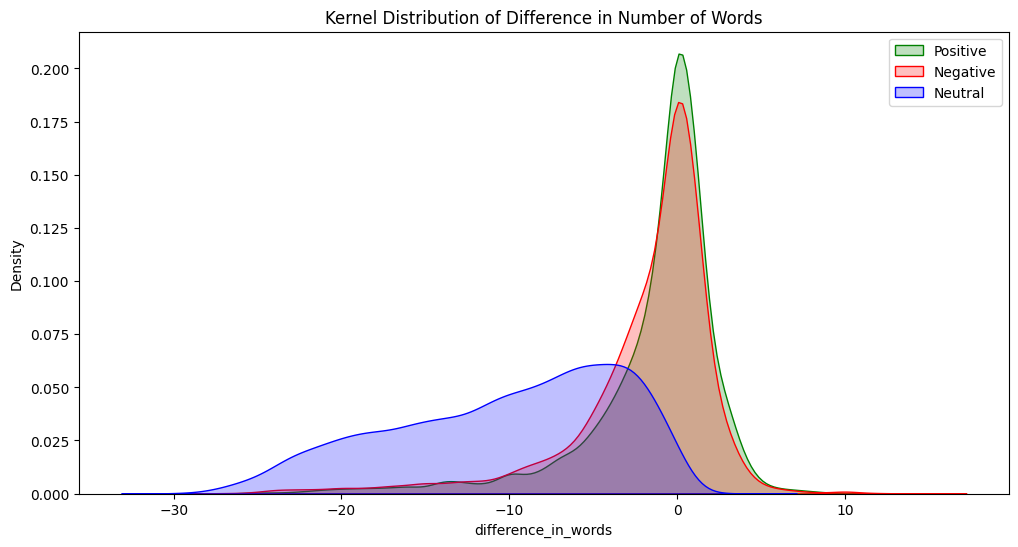

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

original_df['difference_in_words'] = (
    original_df['Num_words_predicted'] - original_df['Num_words_selected']
)

plt.figure(figsize=(12, 6))
plt.title('Kernel Distribution of Difference in Number of Words')

sns.kdeplot(
    original_df[original_df['sentiment'] == 'positive']['difference_in_words'],
    fill=True,
    color="g",
    label="Positive"
)

sns.kdeplot(
    original_df[original_df['sentiment'] == 'negative']['difference_in_words'],
    fill=True,
    color="r",
    label="Negative"
)

sns.kdeplot(
    original_df[original_df['sentiment'] == 'neutral']['difference_in_words'],
    fill=True,
    color="b",
    label="Neutral"
)

plt.legend()
plt.show()


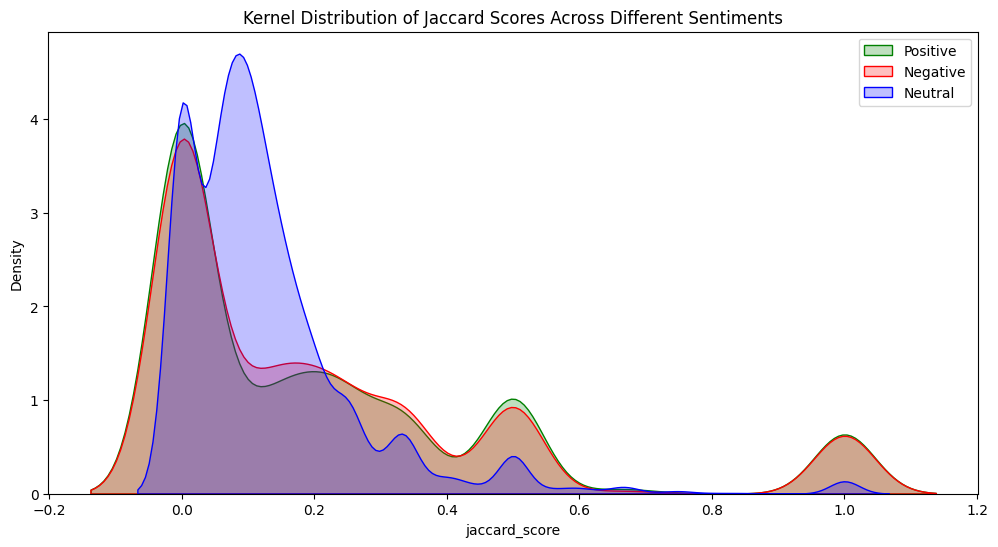

In [ ]:
from sklearn.metrics import jaccard_score

original_df['selected_text'] = original_df['selected_text'].fillna("")
original_df['predicted_selected_text'] = original_df['predicted_selected_text'].fillna("")

def calculate_jaccard(row):
    selected_words = set(row['selected_text'].split())
    predicted_words = set(row['predicted_selected_text'].split())
    if not selected_words:  # Ambos conjuntos vacíos
        return 1.0
    return len(selected_words & predicted_words) / len(selected_words | predicted_words)

original_df['jaccard_score'] = original_df.apply(calculate_jaccard, axis=1)

plt.figure(figsize=(12, 6))
plt.title('Kernel Distribution of Jaccard Scores Across Different Sentiments')

# Distribución para los tweets positivos
sns.kdeplot(
    original_df[original_df['sentiment'] == 'positive']['jaccard_score'],
    fill=True,
    color="g",
    label="Positive"
)

# Distribución para los tweets negativos
sns.kdeplot(
    original_df[original_df['sentiment'] == 'negative']['jaccard_score'],
    fill=True,
    color="r",
    label="Negative"
)

sns.kdeplot(
    original_df[original_df['sentiment'] == 'neutral']['jaccard_score'],
    fill=True,
    color="b",
    label="Neutral"
)

# Agregar leyenda
plt.legend()
plt.show()


In [ ]:
import plotly.express as px
from collections import Counter

# Crear una función para procesar y generar un DataFrame con las palabras más comunes
def get_frequent_words(data, column_name, sent=None, top_n=20):
    if sent is not None:
        data = data[data['sentiment'] == sent]

    words = data[column_name].dropna().str.cat(sep=' ').lower().split()
    frequent_words = Counter(words).most_common(top_n)
    frequent_words_df = pd.DataFrame(frequent_words, columns=["Most frequent words", "Frequency"])
    return frequent_words_df

# Obtener los DataFrames para cada columna
selected_text_frequency = get_frequent_words(original_df, "selected_text")
predicted_text_frequency = get_frequent_words(original_df, "predicted_selected_text")

# Graficar para `selected_text`
fig_selected_text = px.bar(
    selected_text_frequency,
    x="Frequency",
    y="Most frequent words",
    title="Most frquent words in selected text",
    orientation="h",
    width=700,
    height=700,
    color="Most frequent words",
)
fig_selected_text.show()

# Graficar para `predicted_text`
fig_predicted_text = px.bar(
    predicted_text_frequency,
    x="Frequency",
    y="Most frequent words",
    title="Most frquent words in predicted text",
    orientation="h",
    width=700,
    height=700,
    color="Most frequent words",
)
fig_predicted_text.show()


For analysis purposes, let's delete the stop words out of the selected text too to see how they actuale compare.

In [ ]:
original_df["stopwords_selected_text"] = original_df["selected_text"].apply(lambda x: preprocess_tweet(x, remove_stopwords=True))

selected_text_frequency = get_frequent_words(original_df, "stopwords_selected_text")
predicted_text_frequency = get_frequent_words(original_df, "predicted_selected_text")

# Graficar para `selected_text`
fig_selected_text = px.bar(
    selected_text_frequency,
    x="Frequency",
    y="Most frequent words",
    title="Most frquent words in selected text",
    orientation="h",
    width=700,
    height=700,
    color="Most frequent words",
)
fig_selected_text.show()

# Graficar para `predicted_text`
fig_predicted_text = px.bar(
    predicted_text_frequency,
    x="Frequency",
    y="Most frequent words",
    title="Most frquent words in predicted text",
    orientation="h",
    width=700,
    height=700,
    color="Most frequent words",
)
fig_predicted_text.show()

Let's do an analysis based on the sentiment, in this case for just the predicted text vs the selected text

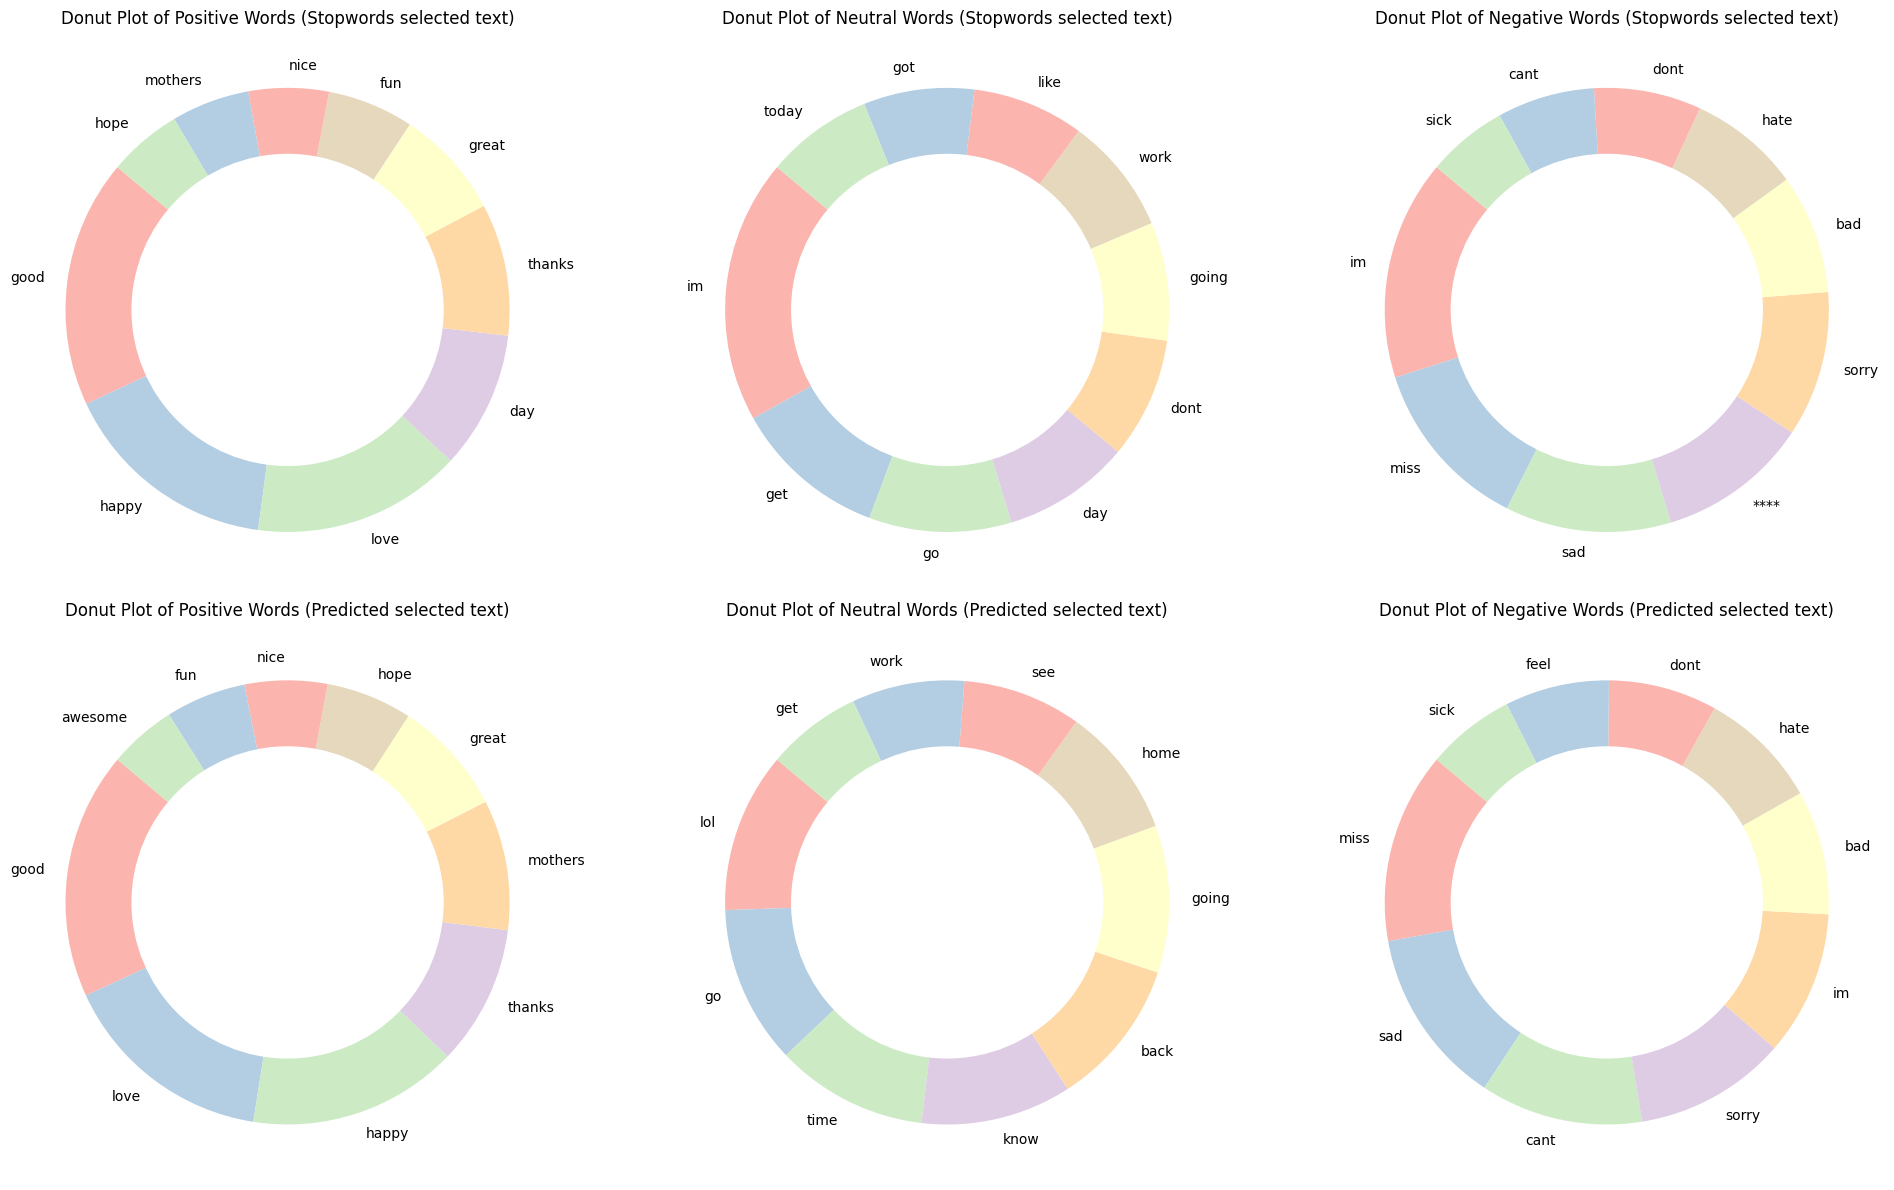

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7

# Crear gráficos de tipo donut
sentiments = ['positive', 'neutral', 'negative']
columns = ['stopwords_selected_text', 'predicted_selected_text']

plt.figure(figsize=(20, 12))  # Configurar tamaño de figura

for i, column in enumerate(columns):  # Iterar por las columnas
    for j, sentiment in enumerate(sentiments):  # Iterar por los sentimientos
        # Obtener palabras más comunes
        common_words = get_frequent_words(original_df, column, sent=sentiment, top_n=10)
        
        # Configurar subgráfico
        plt.subplot(2, 3, i * 3 + j + 1)
        
        # Crear gráfico de tipo donut
        plt.pie(common_words['Frequency'], labels=common_words['Most frequent words'], colors=Pastel1_7.hex_colors, startangle=140)
        my_circle = plt.Circle((0, 0), 0.7, color='white')
        plt.gca().add_artist(my_circle)
        
        # Título del gráfico
        plt.title(f"Donut Plot of {sentiment.capitalize()} Words ({column.replace('_', ' ').capitalize()})")

# Mostrar gráficos
plt.tight_layout()
plt.show()
